In [ ]:
!pip install lazypredict

In [ ]:
import os
import sys
import shutil
import tempfile
import urllib.request
import zipfile
from sklearn.metrics import log_loss, f1_score, roc_curve, auc


TASKS = ["CoLA", "SST", "RTE"]
TASK2PATH = {"CoLA":'https://dl.fbaipublicfiles.com/glue/data/CoLA.zip',
             "SST":'https://dl.fbaipublicfiles.com/glue/data/SST-2.zip',
             "RTE":'https://dl.fbaipublicfiles.com/glue/data/RTE.zip'}

def download_and_extract(task, data_dir):
    print("Downloading and extracting %s..." % task)
    data_file = "%s.zip" % task
    urllib.request.urlretrieve(TASK2PATH[task], data_file)
    with zipfile.ZipFile(data_file) as zip_ref:
        zip_ref.extractall(data_dir)
    os.remove(data_file)
    print("\tCompleted!")
    

def get_tasks(task_names):
    if "all" in task_names:
        tasks = TASKS
    else:
        tasks = []
        for task_name in task_names:
            assert task_name in TASKS, "Task %s not found!" % task_name
            tasks.append(task_name)
    return tasks

def main():
    tasks = get_tasks('all')

    for task in tasks:
      download_and_extract(task, 'data')

main()

	Completed!
	Completed!
	Completed!


# **SST-2 Classifier**

Here we apply only one representation function - word2vec and different configurations of simple LSTM model and basic classifiers

In [ ]:
## SST-2
import pandas as pd

data_pth = 'data'
TASKS = ["CoLA", "SST-2", "RTE"]

train_data = pd.read_table(os.path.join(data_pth, TASKS[1], 'train.tsv'))
test_data = pd.read_table(os.path.join(data_pth, TASKS[1], 'dev.tsv'))

In [ ]:
test_data

,sentence,label
0,it 's a charming and often affecting journey .,1
1,unflinchingly bleak and desperate,0
2,allows us to hope that nolan is poised to emba...,1
3,"the acting , costumes , music , cinematography...",1
4,"it 's slow -- very , very slow .",0
...,...,...
867,has all the depth of a wading pool .,0
868,a movie with a real anarchic flair .,1
869,a subject like this should inspire reaction in...,0
870,... is an arthritic attempt at directing by ca...,0


In [ ]:
x_train = train_data.loc[:,'sentence']
y_train = train_data.loc[:,'label']
x_test = test_data.loc[:,'sentence']
y_test = test_data.loc[:,'label']

In [ ]:
x_train

0             hide new secretions from the parental units 
1                     contains no wit , only labored gags 
2        that loves its characters and communicates som...
3        remains utterly satisfied to remain the same t...
4        on the worst revenge-of-the-nerds clichés the ...
                               ...                        
67344                                 a delightful comedy 
67345                     anguish , anger and frustration 
67346    at achieving the modest , crowd-pleasing goals...
67347                                    a patient viewer 
67348    this new jangle of noise , mayhem and stupidit...
Name: sentence, Length: 67349, dtype: object

## Doc2Vec

In [ ]:
!pip install --upgrade numpy

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

def sent_tokenize(sents):
  tokenized_sent = []
  for s in sents:
    word_tokens = word_tokenize(s.lower())
    filtered_sentence = [w for w in word_tokens if w not in stop_words]
    tokenized_sent.append(filtered_sentence)
  return [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_sent)]

tagged_train_sent = sent_tokenize(x_train)
tagged_test_sent = sent_tokenize(x_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kolma\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kolma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
tagged_train_sent

In [ ]:
vector_size = 100

model_doc2vec = Doc2Vec(tagged_train_sent+tagged_test_sent, vector_size = vector_size, window = 4, min_count = 1, epochs = 100)

In [ ]:
x_train = train_data.loc[:,'sentence']
y_train = train_data.loc[:,'label']
x_test = test_data.loc[:,'sentence']
y_test = test_data.loc[:,'label']

In [ ]:
import tqdm

x_train_preprocessed = [model_doc2vec.infer_vector(word_tokenize(sent.lower())) for sent in tqdm.tqdm(x_train)]
x_test_preprocessed = [model_doc2vec.infer_vector(word_tokenize(sent.lower())) for sent in tqdm.tqdm(x_test)]

100%|██████████| 872/872 [00:03<00:00, 248.69it/s]


In [ ]:
import numpy as np

print(np.array(x_train_preprocessed).shape)

(67349, 100)


In [ ]:
import numpy as np
import pandas as pd


df_train = pd.DataFrame(np.array(x_train_preprocessed).reshape([x_train.shape[0],vector_size]))
df_test = pd.DataFrame(np.array(x_test_preprocessed).reshape([x_test.shape[0],vector_size]))

df_train.to_csv('df_train_doc2vec_256_2.csv')
df_test.to_csv('df_test_doc2vec_256_2.csv')

C:\Users\kolma\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
import pandas as pd

# x_train_preprocessed = pd.read_csv('df_train_doc2vec_100_2.csv')
# x_test_preprocessed = pd.read_csv('df_test_doc2vec_100_2.csv')
# x_train_preprocessed = x_train_preprocessed.drop('Unnamed: 0', axis=1)
# x_test_preprocessed = x_test_preprocessed.drop('Unnamed: 0', axis=1)

In [ ]:
len(x_train_preprocessed)

67349

In [ ]:
from lazypredict.Supervised import LazyClassifier
import numpy as np
import pandas as pd

x_valid_preprocessed = x_train_preprocessed[63000:len(x_train_preprocessed)]
x_train_preprocessed = x_train_preprocessed[0:63000]

y_valid = y_train[63000:len(y_train)]
y_train = y_train[0:63000]

print(len(x_valid_preprocessed))
print(len(x_train_preprocessed))
print(len(y_valid))
print(len(y_train))

4349
63000
4349
63000


## Basic classifiers

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)

vector_size=100

models,predictions = clf.fit(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), 
                             np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), 
                             y_train, y_valid)

print(models)

100%|██████████| 29/29 [1:28:08<00:00, 182.35s/it]   


                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NuSVC                              0.74               0.72     0.72      0.73   
KNeighborsClassifier               0.70               0.69     0.69      0.70   
SVC                                0.72               0.69     0.69      0.70   
ExtraTreesClassifier               0.69               0.66     0.66      0.67   
RandomForestClassifier             0.68               0.66     0.66      0.67   
XGBClassifier                      0.67               0.66     0.66      0.66   
LGBMClassifier                     0.66               0.64     0.64      0.64   
QuadraticDiscriminantAnalysis      0.64               0.61     0.61      0.62   
CalibratedClassifierCV             0.63               0.61     0.61      0.61   
LinearSVC                          0.63               0.61     0.61      0.61   
LogisticRegression          

In [ ]:
models = clf.provide_models(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), y_train, y_valid)
predictions = models['NuSVC'].predict(np.array(x_test_preprocessed).reshape([x_test.shape[0],vector_size]))

print(sum([predictions[i] == y_test[i] for i in range(len(x_test))]), len(x_test))

512 872


BERT, best general classifier, no balancing techniques
F-measure or f1-score:  0.7019867549668874
Log loss:  14.259439639098753
AUC:  0.5802812157952345
Classification Report:
              precision    recall  f1-score   support

           1     0.5550    0.9550    0.7020       444
           0     0.8148    0.2056    0.3284       428

    accuracy                         0.5872       872
   macro avg     0.6849    0.5803    0.5152       872
weighted avg     0.6825    0.5872    0.5186       872



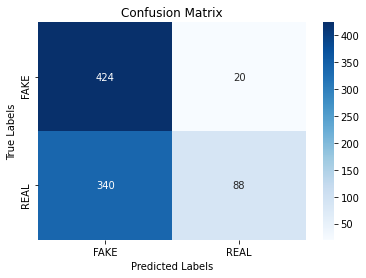

In [ ]:
from sklearn.metrics import log_loss, f1_score, roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def eval(y_true, y_pred):
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
# model evaluation

print("BERT, best general classifier, no balancing techniques")
print("F-measure or f1-score: ", f1_score(y_test, predictions))
print("Log loss: ", log_loss(y_test, predictions))

fpr, tpr, thresholds = roc_curve(y_test, predictions)

print("AUC: ", auc(fpr, tpr))

eval(y_test, predictions)

## LSTM architecture 1

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from keras.layers import Bidirectional

In [ ]:
lstm = Sequential()
lstm.add(Bidirectional(LSTM(100, return_sequences=False)))
lstm.add(Dense(1, activation='sigmoid'))

callback = EarlyStopping(monitor='val_loss', patience=7)

lstm.compile(loss='binary_crossentropy', optimizer='adam')
lstm.fit(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),1,vector_size]), y_train, validation_data=(np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),1,vector_size]), y_valid), epochs=50, batch_size=128, verbose=1, shuffle=True, callbacks=[callback])


Epoch 1/50
493/493 [==============================] - 6s 6ms/step - loss: 0.6474 - val_loss: 0.6417

In [ ]:
import math

predictions_lstm = lstm.predict(np.array(x_test_preprocessed).reshape([len(x_test_preprocessed),1,vector_size]))

print(sum([math.ceil(predictions_lstm[i]) == y_test[i] for i in range(len(x_test))]), len(x_test))

444 872


Doc2Vec, LSTM, no balancing techniques
F-measure or f1-score:  0.6747720364741641
Log loss:  nan
Log loss:  16.95291115220401
AUC:  0.7558121790014314
AUC:  0.5
Classification Report:
              precision    recall  f1-score   support

           1     0.5092    1.0000    0.6748       444
           0     0.0000    0.0000    0.0000       428

    accuracy                         0.5092       872
   macro avg     0.2546    0.5000    0.3374       872
weighted avg     0.2593    0.5092    0.3436       872



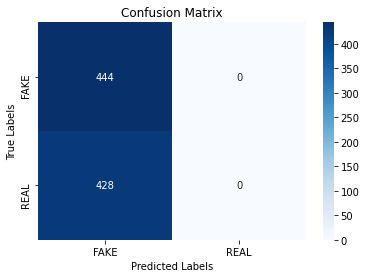

In [ ]:
# model evaluation

print("Doc2Vec, LSTM, no balancing techniques")
print("F-measure or f1-score: ", f1_score(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))
print("Log loss: ", log_loss(y_test, predictions_lstm))
print("Log loss: ", log_loss(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))

fpr, tpr, thresholds = roc_curve(y_test, predictions_lstm)

print("AUC: ", auc(fpr, tpr))

fpr, tpr, thresholds = roc_curve(y_test,[math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])

print("AUC: ", auc(fpr, tpr))

eval(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])

## LSTM architecture 2

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from keras.layers import Bidirectional

In [ ]:
embedding_vecor_length = 100
max_review_length=500
top_words=7500

lstm = Sequential()
# lstm.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
lstm.add(LSTM(100))
lstm.add(Dense(1, activation='sigmoid'))

callback = EarlyStopping(monitor='val_loss', patience=7)

lstm.compile(loss='binary_crossentropy', optimizer='adam')
lstm.fit(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),1,vector_size]), y_train, validation_data=(np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),1,vector_size]), y_valid), epochs=50, batch_size=128, verbose=1, shuffle=True, callbacks=[callback])


Epoch 1/50
493/493 [==============================] - 5s 6ms/step - loss: 0.6510 - val_loss: 0.6406

In [ ]:
import math

predictions_lstm = lstm.predict(np.array(x_test_preprocessed).reshape([len(x_test_preprocessed),1,vector_size]))

print(sum([math.ceil(predictions_lstm[i]) == y_test[i] for i in range(len(x_test))]), len(x_test))

444 872


Doc2Vec, LSTM, no balancing techniques
F-measure or f1-score:  0.6747720364741641
Log loss:  nan
Log loss:  16.95291115220401
AUC:  0.7646975246274312
AUC:  0.5
Classification Report:
              precision    recall  f1-score   support

           1     0.5092    1.0000    0.6748       444
           0     0.0000    0.0000    0.0000       428

    accuracy                         0.5092       872
   macro avg     0.2546    0.5000    0.3374       872
weighted avg     0.2593    0.5092    0.3436       872



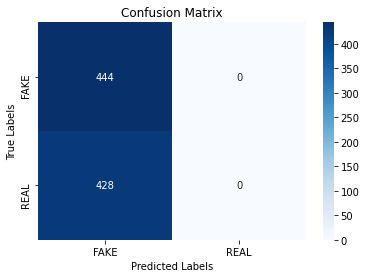

In [ ]:
# model evaluation

print("Doc2Vec, LSTM, no balancing techniques")
print("F-measure or f1-score: ", f1_score(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))
print("Log loss: ", log_loss(y_test, predictions_lstm))
print("Log loss: ", log_loss(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))

fpr, tpr, thresholds = roc_curve(y_test, predictions_lstm)

print("AUC: ", auc(fpr, tpr))

fpr, tpr, thresholds = roc_curve(y_test,[math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])

print("AUC: ", auc(fpr, tpr))

eval(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])

## LSTM architecture 3

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from keras.layers import Bidirectional

In [ ]:
lstm = Sequential()
lstm.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
lstm.add(Dropout(0.2))
lstm.add(Dense(1, activation='sigmoid'))

callback = EarlyStopping(monitor='val_loss', patience=7)

lstm.compile(loss='binary_crossentropy', optimizer='adam')
lstm.fit(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),1,vector_size]), y_train, validation_data=(np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),1,vector_size]), y_valid), epochs=50, batch_size=128, verbose=1, shuffle=True, callbacks=[callback])


Epoch 1/50
493/493 [==============================] - 12s 11ms/step - loss: 0.6567 - val_loss: 0.6447

In [ ]:
import math

predictions_lstm = lstm.predict(np.array(x_test_preprocessed).reshape([len(x_test_preprocessed),1,vector_size]))

print(sum([math.ceil(predictions_lstm[i]) == y_test[i] for i in range(len(x_test))]), len(x_test))

444 872


Doc2Vec, LSTM, no balancing techniques
F-measure or f1-score:  0.6747720364741641
Log loss:  nan
Log loss:  16.95291115220401
AUC:  0.7585248800202071
AUC:  0.5
Classification Report:
              precision    recall  f1-score   support

           1     0.5092    1.0000    0.6748       444
           0     0.0000    0.0000    0.0000       428

    accuracy                         0.5092       872
   macro avg     0.2546    0.5000    0.3374       872
weighted avg     0.2593    0.5092    0.3436       872



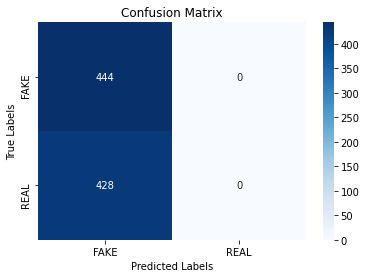

In [ ]:
# model evaluation

print("Doc2Vec, LSTM, no balancing techniques")
print("F-measure or f1-score: ", f1_score(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))
print("Log loss: ", log_loss(y_test, predictions_lstm))
print("Log loss: ", log_loss(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))

fpr, tpr, thresholds = roc_curve(y_test, predictions_lstm)

print("AUC: ", auc(fpr, tpr))

fpr, tpr, thresholds = roc_curve(y_test,[math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])

print("AUC: ", auc(fpr, tpr))

eval(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])
